2022-03-30 15:55:06,226 - INFO     - [              faceit.player              : 207] - Request player -mblw- details
2022-03-30 15:55:06,485 - INFO     - [              faceit.matches_stats       : 218] - Request 151e83ca-1f8e-4d22-b042-7fb439402b29 statistics history


Get match details done for 1
Get match details done for 101
Get match details done for 201
Get match details done for 301


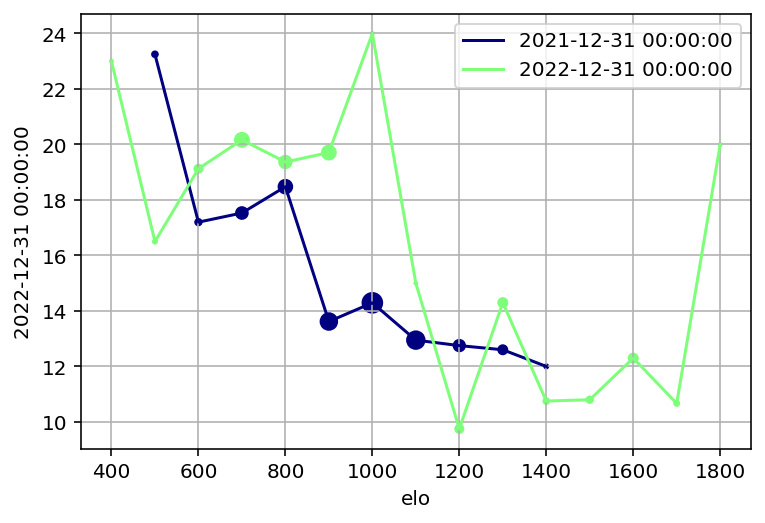

In [2]:
from matplotlib import cm
%config InlineBackend.figure_format = 'retina'

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from faceit.faceit import Faceit

faceit = Faceit()

nickname = "-mblw-"
# nickname = "_zhk"
# nickname = "-huracan--"

player = faceit.player(nickname)
statistics = faceit.matches_stats(player.player_id)

table = []
for index, stats in enumerate(statistics):
    if index % 100 == 0:
        print(f"Get match details done for {index + 1}")
    # print(f"Get {index + 1} match details for {stats.match_id}")
    match = faceit.match(stats.match_id)
    for teammate in match.get_players_team(player):
        entry = {
            "match_id": match.match_id,
            "date": match.date,
            "nickname": teammate.nickname,
            "elo": teammate.elo,
        }
        if teammate == player:
            entry["kd"] = stats.info.kills
        table.append(entry)

df = pd.DataFrame(table)

fig = plt.figure()
ax = fig.add_subplot(111)

cmap = cm.get_cmap('jet')

group_by_date = df.groupby(by=pd.Grouper(key="date", freq='Y'))

for index, (name, group) in enumerate(group_by_date):
    group_elo = group.groupby(by="match_id")\
        .aggregate({"elo": "mean"})\
        .reset_index()
    group_elo.columns = ["match_id", "mean_elo"]

    group_merged = group.dropna() \
        .merge(group_elo, on="match_id", how="outer") \
        .sort_values(by=["mean_elo"]) \
        .reset_index()

    group_merged["level"] = (group_merged["mean_elo"] / 100).round(decimals=0) * 100

    group_by_level = group_merged.groupby(by="level")

    group_hist = group_by_level.aggregate({"kd": ["mean", "count"]}).reset_index()
    group_hist.columns = ["elo", name, "count"]
    group_hist["count"] = group_hist["count"].astype(int)

    color = cmap(index / len(group_by_date))

    group_hist.plot(ax=ax, x="elo", y=name, color=color)
    group_hist.plot.scatter(ax=ax, x="elo", y=name, s=group_hist["count"] * 2, color=color)
    # for _, row in group_hist.iterrows():
    #     label = "{:.0f}".format(row["count"])
    #     ax.annotate(label, (row["elo"], row[name]))

ax.grid()